# Description
The first part is focused on inferring the missing value about skin color rating using machine learning algorithm. The second part try to infer wether referees' behavior change depending of the skin-color of the player.

Let start by doing some imports.

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import seaborn as sns                                   # For pretty plots

N_JOBS = 1                                              # Number of parallel jobs to be executed at the same time

## Skin-color inferring
First, let have a look to [mathewzila's suggestion](https://github.com/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) where the dataset is a disaggregate version of `data/CrowdstormingDataJuly1st.csv`. By _disaggregate_, we means that there is one observation per game between a player and a referee (in place of one observation per dyad).

Depending of the computations, this dataset might be a better option. Both will be imported in order to do some comparison.

In [2]:
df = pd.read_csv(os.path.join('data', 'CrowdstormingDataJuly1st.csv'))
print(df.head(10))

          playerShort              player               club leagueCountry  \
0       lucas-wilchez       Lucas Wilchez      Real Zaragoza         Spain   
1          john-utaka          John Utaka    Montpellier HSC        France   
2         abdon-prats         Abdón Prats       RCD Mallorca         Spain   
3          pablo-mari          Pablo Marí       RCD Mallorca         Spain   
4          ruben-pena          Rubén Peña    Real Valladolid         Spain   
5        aaron-hughes        Aaron Hughes          Fulham FC       England   
6  aleksandar-kolarov  Aleksandar Kolarov    Manchester City       England   
7    alexander-tettey    Alexander Tettey       Norwich City       England   
8   anders-lindegaard   Anders Lindegaard  Manchester United       England   
9        andreas-beck        Andreas Beck    1899 Hoffenheim       Germany   

     birthday  height  weight              position  games  victories  \
0  31.08.1983   177.0    72.0  Attacking Midfielder      1          

In [3]:
dfd = pd.read_csv(os.path.join('data', 'crowdstorm_disaggregated.csv'))
dfd.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,0,0,30
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,0,0,30
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,0,0,30


In [4]:
df_cols = set(df.columns)
dfd_cols = set(dfd.columns)

print("Number of lost columns: {}".format(len(df_cols - dfd_cols)))

Number of lost columns: 0


As we can see, the deaggregated dataset doesn't remove any columns from the base data set.

In [5]:
print("New columns: {}".format(dfd_cols - df_cols))

New columns: {'allreds', 'refCount', 'allredsStrict', 'skintone'}


As we can see, new columns are created. Based on [source code](https://osf.io/w7tds/),

- allredsStrict: If player has received a red without a yellow
- allreds: If player has received a red during this game (either because he had a yellow one before, or if he's directly received a red)
- skintone: Average of rater1 and rater2 for this player
- refCount: Number of dyads per referee (thus, how many player the referee is linked to)

All are indicator variable (either 1 if true, 0 o.w.)

**Remark**: the field `games` (i.e. count the number of match between the player and the referee) is redundant on `dfd`, since there is one observation per game.

In [6]:
print("All fields: {}".format(dfd.columns))

All fields: Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'skintone', 'allreds', 'allredsStrict',
       'refCount'],
      dtype='object')


Let add a `skintone` field to the aggregated version of the data

In [7]:
df['skintone'] = 0.5 * (df['rater1']+df['rater2'])
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN


### Look on skintone
As mentioned before, `skintone` is the mean between the two skin-color ratings

In [8]:
df_skinton = df[["playerShort", "skintone"]].reset_index().groupby('playerShort', axis=0).mean()
mean_skin = set(df_skinton['skintone'].dropna().unique().tolist())

unique_skin = set(df['skintone'].dropna().unique().tolist())

print("Values not in both: {}".format(mean_skin.symmetric_difference(unique_skin)))


Values not in both: set()


One error in the dataset might have been to have several different `skintone` value for the same user. As the previous code suggests, the mean of the `skintone` over a player doesn't create new value (suggesting that all the `skintone` for a player are the same).

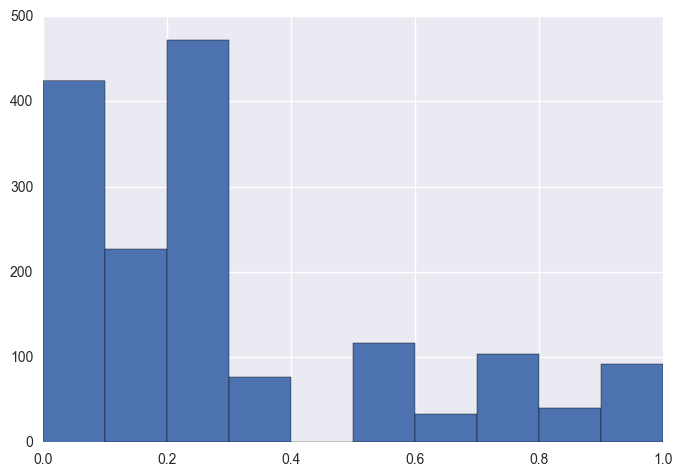

In [9]:
df_skinton['skintone'].dropna().hist()

As we can see, there are more players with a white skin than with a dark one. This need to be taken into consideration for the analysis.

### Information about players

In [10]:
referee_per_player = df.groupby('playerShort').count()['player']
referee_per_player.describe()

count    2053.000000
mean       71.129079
std        36.171246
min         1.000000
25%        45.000000
50%        67.000000
75%        92.000000
max       202.000000
Name: player, dtype: float64

We can see that player have played with a lot of different referee, in general. 

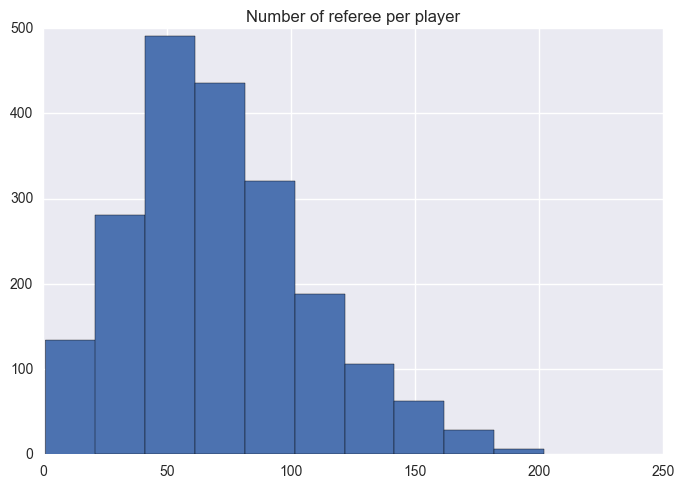

In [11]:
referee_per_player.hist()
plt.title('Number of referee per player')

One issue that might arise is for player having played with only a few referee. Let arbitrarly check for player have played with less than 5 different referees

In [12]:
(referee_per_player < 5).sum()

39

Let see the full data for these players

In [13]:
player_low_n_referees = df.set_index('playerShort')[referee_per_player < 5]
player_low_referee_ratio = player_low_n_referees['skintone'].isnull().mean()

print("P(no skintone | player has less 5 different referees) = {:0.1f}%".format(player_low_referee_ratio * 100))

P(no skintone | player has less 5 different referees) = 79.7%


/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


As we can see, we don't have skintone information for roughly 80% of the players that have less than 5 different referees. This means that it might be hard to predict the skintone for these players.

The situation might be very significant for player having only one referee linked to it.

In [14]:
player_one_referee = df.set_index('playerShort')[referee_per_player == 1]
player_one_referee_ratio = player_one_referee['skintone'].isnull().mean()

print("P(no skintone information | player has only one referee linked to him) = {:0.1f}%".format(player_one_referee_ratio*100))

P(no skintone information | player has only one referee linked to him) = 77.8%


/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


For these players, it might be harder to infer skintone.

### Numerize categories
Some field are categories but with a string representation. This breaks the random forest algorithm. In this part, we categorize the field as numeric value. 

** Remark **: Using numeric field has the issue of being ordered (where the categories aren't ordered). But, one alternative is to use dummy features. At this part of the process, dummies features would add a lot of explanatory variable. Therefore, we don't create dummy features yet.

In [15]:
LABEL_FIELDS = ['club', 'leagueCountry', 'position', 'Alpha_3']
UNKNOWN_LABEL = 'MISSING'

label_encoders = {}

from sklearn.preprocessing import LabelEncoder

df_categorized = df.copy()

for label in LABEL_FIELDS:
    encoder = LabelEncoder()
    values = df_categorized[label].fillna(UNKNOWN_LABEL, inplace=False)
    encoder.fit(values)
    transformed = encoder.transform(values)
    df_categorized[label] = transformed
    
    label_encoders[label] = encoder
    
    
# Special case for the skintone where we need to keep NaN values
encoder = LabelEncoder()
skintone = df_categorized['skintone']
skintone = skintone[skintone.notnull()]
encoder.fit(skintone)
df_categorized.loc[skintone.index, 'skintone'] = encoder.transform(skintone)
label_encoders['skintone'] = encoder

df_categorized.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,82,3,31.08.1983,177.0,72.0,0,1,0,...,1,1,60,0.326391,712.0,0.000564,0.396000,750.0,0.002696,3.0
1,john-utaka,John Utaka,62,1,08.01.1982,179.0,82.0,12,1,0,...,2,2,159,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,6.0
2,abdon-prats,Abdón Prats,73,3,17.12.1992,181.0,79.0,9,1,0,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
3,pablo-mari,Pablo Marí,73,3,31.08.1993,191.0,87.0,1,1,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
4,ruben-pena,Rubén Peña,81,3,18.07.1991,172.0,70.0,11,1,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
5,aaron-hughes,Aaron Hughes,42,0,08.11.1979,182.0,71.0,1,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
6,aleksandar-kolarov,Aleksandar Kolarov,59,0,10.11.1985,187.0,80.0,6,1,1,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
7,alexander-tettey,Alexander Tettey,65,0,04.04.1986,180.0,68.0,4,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,8.0
8,anders-lindegaard,Anders Lindegaard,60,0,13.04.1984,193.0,80.0,5,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,2.0
9,andreas-beck,Andreas Beck,2,2,13.03.1987,180.0,70.0,10,1,1,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0


## Clean height and width

In [63]:
from sklearn.preprocessing import scale

COLS = ['height', 'weight']

for c in COLS:
    col_values = df_categorized[c].copy()
    col_values[col_values.isnull()] = np.mean(col_values[col_values.notnull()])
    
    df_categorized[c] = scale(col_values)
    
    
df_categorized_copy = df_categorized.copy()

# Predicting
This part focuses on predicting the `skintone`.

## Baseline
First, let try to do a naive classification with the metric:
$$
cost(p) = \sum_{a \in A(p)} \cfrac{IAT(a)(\text{Yellow}(p, a) + 3\text{Reds}(p,a))}{\sum_{a\in A(p)} \text{Game}(a, p)},
$$
where $IAT(a)$ is the IAT of the referee $a$, Yellow$(p,a)$ is the number of yellow cards given by $a$ to player $p$, and reds is the number of red cards (similarly than for the yellow), Game$(a,p)$ is the number of games played between $p$ and $a$.

We slighlty count that reds are more importants then yellows. Also, note that with this metric the red cards reveived by successive yellow cards are counted more than red cards given directly.

In [16]:
with pd.option_context('display.max_columns', 100):
    print(df_categorized.head(5))

     playerShort         player  club  leagueCountry    birthday  height  \
0  lucas-wilchez  Lucas Wilchez    82              3  31.08.1983   177.0   
1     john-utaka     John Utaka    62              1  08.01.1982   179.0   
2    abdon-prats    Abdón Prats    73              3  17.12.1992   181.0   
3     pablo-mari     Pablo Marí    73              3  31.08.1993   191.0   
4     ruben-pena     Rubén Peña    81              3  18.07.1991   172.0   

   weight  position  games  victories  ties  defeats  goals  yellowCards  \
0    72.0         0      1          0     0        1      0            0   
1    82.0        12      1          0     0        1      0            1   
2    79.0         9      1          0     1        0      0            1   
3    87.0         1      1          1     0        0      0            0   
4    70.0        11      1          1     0        0      0            0   

   yellowReds  redCards    photoID  rater1  rater2  refNum  refCountry  \
0           

In [17]:
df_subset = df_categorized[['playerShort', 'club', 'leagueCountry', 'position','games', 'yellowCards', 'redCards', 'meanIAT', 'skintone']].copy()

for f in ['meanIAT', 'yellowCards', 'redCards']:
    df_subset[f].fillna(0, inplace=True)

df_subset["cost"] = df_subset['meanIAT']*(df_subset['yellowCards'] + 3*df_subset['redCards']) / df_subset['games']

In [18]:
def check_field_uniqueness_per_player(df, field):
    """
    Check if the field is unique on a user basis
    Example:
      - Player one: [1,1,1,1]  -> Unique 
      - Player two: [1,1,1,2]  -> Non-unique
      - Player three: [2,2,2]  -> Unique (even if not the same as player one)

    Return if uniqueness holds for every player.
    """
    fields = list(set(['playerShort', field]))
    number_different_value_per_player = df[fields].groupby('playerShort')[field].nunique()
        
    return not any(number_different_value_per_player > 1)

non_unique_fields = []
for f in ['club', 'leagueCountry', 'position', 'skintone']:
    if not check_field_uniqueness_per_player(df_subset, f):
        non_unique_fields.append(f)
        
if len(non_unique_fields) > 0:
    print("Non-unique fields: {}".format(non_unique_fields))
else:
    print("All tested fields are unique for a player")


All tested fields are unique for a player


As we can see, each tested field is unique per player. This means that the data is quite clean (there is no case where the player-specific data is different between two player-referee dyad). Thus, for these fields, we can take an element of the grouped list as aggregator function.

In [19]:
df_grouped = df_subset.groupby('playerShort')

df_final = df_grouped.agg({
        'club': 'first',
        'leagueCountry': 'first',
        'position': 'first',
        'cost': 'sum',
        'skintone': 'first'
    })


df_final.head(10)

,cost,position,club,skintone,leagueCountry
playerShort,,,,,
aaron-hughes,1.953444,1,42,1.0,0
aaron-hunt,3.583045,0,110,1.0,2
aaron-lennon,0.643299,11,100,2.0,0
aaron-ramsey,5.252303,3,8,0.0,0
abdelhamid-el-kaoutari,1.171792,1,62,2.0,1
abdon-prats,2.034415,9,73,NaN,3
abdou-dampha,1.179793,0,5,NaN,1
abdou-traore_2,1.332483,11,44,6.0,1
abdoul-camara,0.979174,8,40,NaN,1


### Training

In [20]:
def split_training_predicting(df, y_label):
    """
    Given a y_label, return the training set (where y_label != NaN), and the predict set
    (where y_label == NaN).
    """
    x_predict = df[df[y_label].isnull()].drop(y_label, 1)
    
    training = df[df[y_label].notnull()]
    y_training = training[y_label]
    x_training = training.drop(y_label, 1)
    
    return (x_training, y_training, x_predict)

(x_training, y_training, x_predict) = split_training_predicting(df_final, 'skintone')

number_of_estimators = list(range(5,100,5))
max_features = list(range(1,df_final.shape[1]))

print(max_features)

params = {
    'n_estimators': number_of_estimators,
    'max_features': max_features,
}

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

estimator = RandomForestClassifier(n_jobs=N_JOBS)    # Strange, looks to work better with 1 job than with max number
gscv = GridSearchCV(estimator, params, cv=10)
cv_result = gscv.fit(x_training, list(y_training))

[1, 2, 3, 4]


In [21]:
print(cv_result.best_score_)
cv_result.best_params_

0.307255520505


{'max_features': 3, 'n_estimators': 60}

### Learning curve 
Now that we've a good set of parameter, we can plot the learning curves

<module 'matplotlib.pyplot' from '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

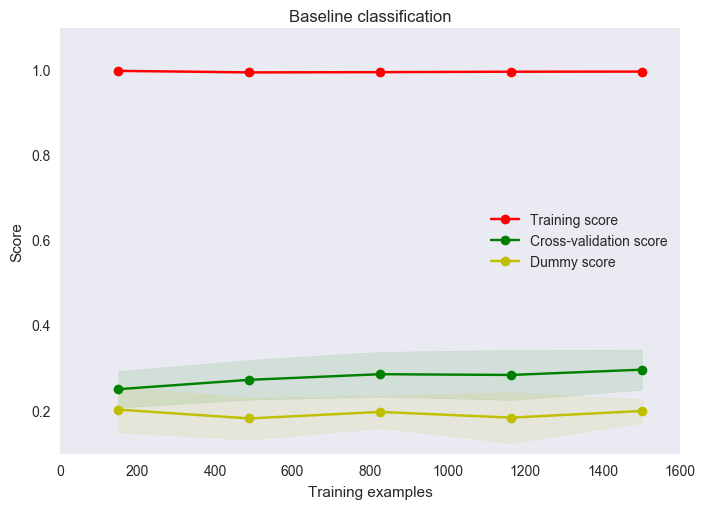

In [22]:
import helpers

from sklearn.dummy import DummyClassifier

estimator = RandomForestClassifier(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
dummy_estimator = DummyClassifier()

helpers.plot_learning_curve(estimator, 'Baseline classification', x_training, y_training,n_jobs=N_JOBS, cv=20, dummy=dummy_estimator)

As [this guide](http://scikit-learn.org/stable/modules/model_evaluation.html) explains, Scikit is based on maximizing the score. As we can see, the _Cross-validation score_ is quite low. Hoepfully, a dummy classifier is slightly less efficient.

## Regression baseline
It's possible to interpret the skintone as a continuous value, thus we can predict it using a RandomForestRegressor.

First, we need to have continuous $y$ values:

In [23]:
df_subset['skintone'] = df['skintone'].copy()

df_grouped = df_subset.groupby('playerShort')

df_final = df_grouped.agg({
        'club': 'first',
        'leagueCountry': 'first',
        'position': 'first',
        'cost': 'sum',
        'skintone': 'first'
    })


df_final.head(10)

,cost,position,club,skintone,leagueCountry
playerShort,,,,,
aaron-hughes,1.953444,1,42,0.125,0
aaron-hunt,3.583045,0,110,0.125,2
aaron-lennon,0.643299,11,100,0.250,0
aaron-ramsey,5.252303,3,8,0.000,0
abdelhamid-el-kaoutari,1.171792,1,62,0.250,1
abdon-prats,2.034415,9,73,NaN,3
abdou-dampha,1.179793,0,5,NaN,1
abdou-traore_2,1.332483,11,44,0.750,1
abdoul-camara,0.979174,8,40,NaN,1


In [24]:
(x_training, y_training, x_predict) = split_training_predicting(df_final, 'skintone')

number_of_estimators = list(range(5,100,5))
max_features = list(range(1,df_final.shape[1]))

print(max_features)

params = {
    'n_estimators': number_of_estimators,
    'max_features': max_features,
}

from sklearn.ensemble import RandomForestRegressor

REGRESSION_SCORING = 'neg_mean_squared_error'

estimator = RandomForestRegressor()
gscv = GridSearchCV(estimator, params, cv=10, scoring=REGRESSION_SCORING)
cv_result = gscv.fit(x_training, list(y_training))

[1, 2, 3, 4]


In [25]:
print(cv_result.best_score_)
print(cv_result.best_params_)

-0.0829897854562
{'n_estimators': 90, 'max_features': 1}


### Learning curve

<module 'matplotlib.pyplot' from '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

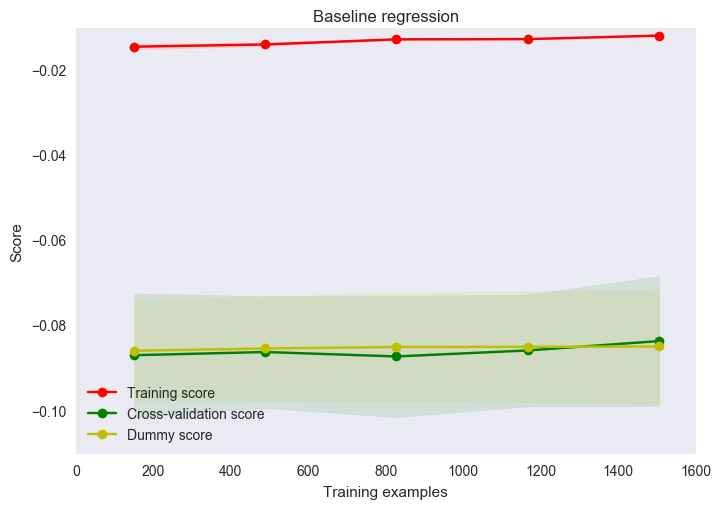

In [26]:
from sklearn.dummy import DummyRegressor

dummy_estimator = DummyRegressor()

estimator = RandomForestRegressor(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
helpers.plot_learning_curve(estimator, 'Baseline regression', x_training, y_training,n_jobs=N_JOBS, cv=20, dummy=dummy_estimator, scoring=REGRESSION_SCORING)

As we can see, the RandomForestRegressor doesn't perform better than a DummyRegressor which simply outputs the mean of the training set. 

** Remark ** : The score is negative by convention of Scikit (it maximizes the score, and minimizing the error is the same as maximizing the negative error)

### Baseline conclusion
As we can see, neither the classification baseline nor the regression baseline perform well. It clearly suggests that the features are the issue.

More work needs to be done to output meaningful features.

## Position or team based feature
This part is based on the assumption that the referee gives cards based on two criterias:

- Position of the player (which influence what he might try to do)
- An implicit racism (IAT)

Taken from the other side, this might allow to predict the skintone based on the position of the player, the implicit racism, and the number of card given.

Roughly, for two players at the same position, a black one will have a card more easily if the referee has a high IAT.

In [49]:
df_categorized.dtypes

playerShort       object
player            object
club               int64
leagueCountry      int64
birthday          object
height           float64
weight           float64
position           int64
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID           object
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3            int64
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
skintone         float64
dtype: object

In [50]:
summed_positions = df_categorized.groupby('position')[['games', 'yellowCards', 'yellowReds', 'redCards', 'meanIAT']].sum()
summed_positions

,games,yellowCards,yellowReds,redCards,meanIAT
position,,,,,
0,33832,4174,89,93,4111.265040
1,67018,10663,396,445,7798.063616
2,53808,5550,144,196,6492.136768
3,18530,2778,79,76,2116.903933
4,47921,8991,291,200,5458.547361
5,35829,1624,13,156,4258.529492
6,28914,4283,135,136,3435.732039
7,20468,2571,87,78,2285.282482
8,14984,1683,38,39,1676.162398


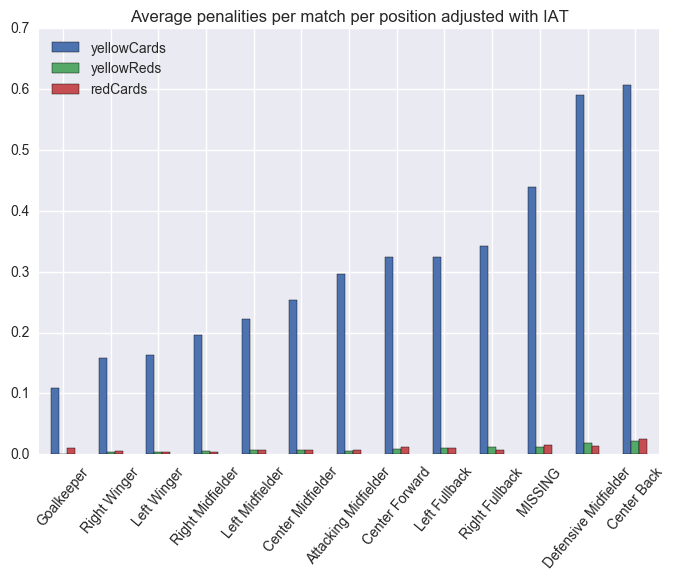

In [51]:
average_value_per_position = summed_positions.copy()

# Normalize cartons columns per number of games
for c in ['yellowCards', 'yellowReds', 'redCards']:
    average_value_per_position[c] = average_value_per_position[c] / average_value_per_position['games']
    
# Normalize meanIAT by number of referee for this position
number_referee_per_position = df_categorized.groupby('position')['refNum'].nunique()
average_value_per_position['meanIAT'] = average_value_per_position['meanIAT'] / number_referee_per_position

average_value_per_position.drop('games', axis=1, inplace=True)

# Take the product of meanIAT and cards
for c in ['yellowCards', 'yellowReds', 'redCards']:
    average_value_per_position[c] = average_value_per_position[c] * average_value_per_position['meanIAT']

plot_avg = average_value_per_position.drop('meanIAT', axis=1).copy()
plot_avg.index = plot_avg.index.map(label_encoders['position'].inverse_transform)

plot_avg.sort_values('yellowCards').plot(kind='bar', title='Average penalities per match per position adjusted with IAT', rot=50)

### Aggregate aggregate per player (by keeing the same means)

In [115]:
df_subset = df_categorized_copy[['playerShort', 'club', 'leagueCountry', 'position','games', 'yellowCards', 'redCards', 'yellowReds', 'meanIAT', 'skintone', 'seIAT', 'weight', 'height']].copy()

df_subset['seIAT'].fillna(0, inplace=True)

print(df_subset.seIAT.isnull().any())

per_player = df_subset.groupby('playerShort').agg({
        'club': 'first',
        'leagueCountry': 'first',
        'position': 'first',
        'games':'sum',
        'yellowCards': 'sum', 
        'redCards': 'sum', 
        'yellowReds': 'sum',
        'meanIAT': 'mean', 
        'seIAT': 'std',
        'skintone': 'first',
        'weight':'first',
        'height': 'first'
    })

if any(per_player.seIAT.isnull()):
    per_player.seIAT.fillna(0, inplace=True)

# Normalize cards
for c in ['redCards', 'yellowCards', 'yellowReds']:
    per_player[c] = per_player[c] / per_player['games']

# Add position specific attributes
END_PADDING = "PositionAvg"

for c in average_value_per_position.columns.values:
    final_column = c + END_PADDING
    value_for_position = lambda pos: average_value_per_position.loc[pos, c]
    per_player[final_column] = per_player['position'].apply(value_for_position)
    
per_player

False


,meanIAT,yellowReds,height,weight,position,redCards,games,club,skintone,yellowCards,seIAT,leagueCountry,yellowCardsPositionAvg,yellowRedsPositionAvg,redCardsPositionAvg,meanIATPositionAvg
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,0.346459,0.000000,0.009515,-7.163118e-01,1,0.000000,654,42,1.0,0.029052,0.003260,0,0.606710,0.022532,0.025320,3.813234
aaron-hunt,0.348818,0.000000,0.158045,-4.340582e-01,0,0.002976,336,110,1.0,0.125000,0.000499,2,0.296623,0.006325,0.006609,2.404249
aaron-lennon,0.345893,0.000000,-2.515500,-1.845326e+00,11,0.000000,412,100,2.0,0.026699,0.001220,0,0.195865,0.004745,0.004187,1.532868
aaron-ramsey,0.346821,0.000000,-0.584606,-1.067788e-02,3,0.003846,260,8,0.0,0.119231,0.028053,0,0.252880,0.007191,0.006918,1.686776
abdelhamid-el-kaoutari,0.331600,0.032258,-0.287545,-4.340582e-01,1,0.016129,124,62,2.0,0.064516,0.006216,1,0.606710,0.022532,0.025320,3.813234
abdon-prats,0.369894,0.000000,-0.139015,4.127025e-01,9,0.000000,36,73,NaN,0.166667,0.000000,3,0.438904,0.011698,0.015729,3.493207
abdou-dampha,0.344125,0.000000,0.306576,-2.929314e-01,0,0.000000,44,5,NaN,0.204545,0.000022,1,0.296623,0.006325,0.006609,2.404249
abdou-traore_2,0.320079,0.010309,-0.287545,-2.929314e-01,11,0.000000,97,44,6.0,0.113402,0.011977,1,0.195865,0.004745,0.004187,1.532868
abdoul-camara,0.330308,0.000000,-0.733136,-8.574386e-01,8,0.000000,142,40,NaN,0.021127,0.004626,1,0.163852,0.003700,0.003797,1.458801


In [116]:
present_fields = ['meanIAT', 'yellowCards', 'redCards', 'yellowReds']
computed_fields = [field + END_PADDING for field in present_fields]

for f in present_fields:
    computed_field = f + END_PADDING
    per_player[f] = (per_player[f] - per_player[computed_field]) * per_player['meanIAT' + END_PADDING]
    
per_player


,meanIAT,yellowReds,height,weight,position,redCards,games,club,skintone,yellowCards,seIAT,leagueCountry,yellowCardsPositionAvg,yellowRedsPositionAvg,redCardsPositionAvg,meanIATPositionAvg
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,-13.219624,-0.085919,0.009515,-7.163118e-01,1,-0.096551,654,42,1.0,-2.202747,0.003260,0,0.606710,0.022532,0.025320,3.813234
aaron-hunt,-4.941765,-0.015206,0.158045,-4.340582e-01,0,-0.008734,336,110,1.0,-0.412623,0.000499,2,0.296623,0.006325,0.006609,2.404249
aaron-lennon,-1.819475,-0.007274,-2.515500,-1.845326e+00,11,-0.006418,412,100,2.0,-0.259310,0.001220,0,0.195865,0.004745,0.004187,1.532868
aaron-ramsey,-2.260204,-0.012130,-0.584606,-1.067788e-02,3,-0.005182,260,8,0.0,-0.225436,0.028053,0,0.252880,0.007191,0.006918,1.686776
abdelhamid-el-kaoutari,-13.276287,0.037088,-0.287545,-4.340582e-01,1,-0.035047,124,62,2.0,-2.067513,0.006216,1,0.606710,0.022532,0.025320,3.813234
abdon-prats,-10.910382,-0.040863,-0.139015,4.127025e-01,9,-0.054944,36,73,NaN,-0.950980,0.000000,3,0.438904,0.011698,0.015729,3.493207
abdou-dampha,-4.953049,-0.015206,0.306576,-2.929314e-01,0,-0.015890,44,5,NaN,-0.221376,0.000022,1,0.296623,0.006325,0.006609,2.404249
abdou-traore_2,-1.859045,0.008529,-0.287545,-2.929314e-01,11,-0.006418,97,44,6.0,-0.126405,0.011977,1,0.195865,0.004745,0.004187,1.532868
abdoul-camara,-1.646247,-0.005397,-0.733136,-8.574386e-01,8,-0.005539,142,40,NaN,-0.208208,0.004626,1,0.163852,0.003700,0.003797,1.458801


### Train the model using the new features

In [117]:
per_player.dtypes

meanIAT                   float64
yellowReds                float64
height                    float64
weight                    float64
position                    int64
redCards                  float64
games                       int64
club                        int64
skintone                  float64
yellowCards               float64
seIAT                     float64
leagueCountry               int64
yellowCardsPositionAvg    float64
yellowRedsPositionAvg     float64
redCardsPositionAvg       float64
meanIATPositionAvg        float64
dtype: object

In [119]:
added_feature_data = per_player[['yellowReds', 'meanIAT', 'skintone', 'redCards', 'position', 'club', 'yellowCards', 'leagueCountry', 'height','weight', 'seIAT']].copy()

(x_training, y_training, x_predict) = split_training_predicting(added_feature_data, 'skintone')

In [120]:
estimator = RandomForestClassifier(n_jobs=N_JOBS)
gscv = GridSearchCV(estimator, params, cv=10)
cv_result = gscv.fit(x_training, list(y_training))

In [121]:
cv_result.best_score_

0.31356466876971612

Unfortunately, the error isn't much better than the baseline.

### Learning curve

<module 'matplotlib.pyplot' from '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

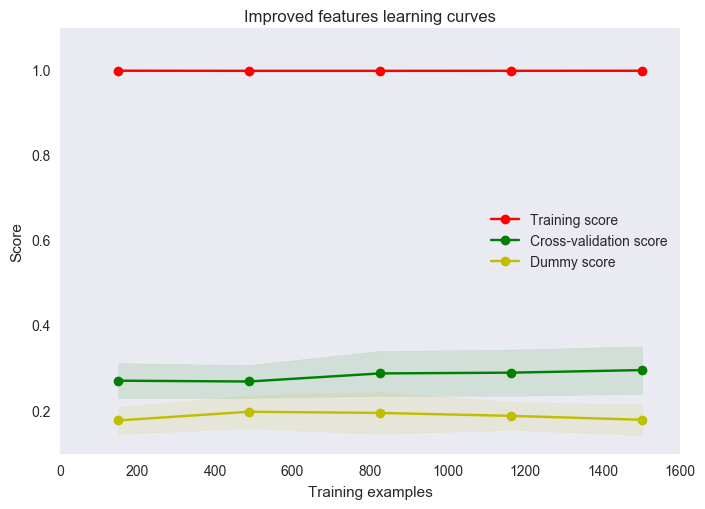

In [122]:
estimator = RandomForestClassifier(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
dummy_estimator = DummyClassifier()

helpers.plot_learning_curve(estimator, 'Improved features learning curves', x_training, y_training,n_jobs=N_JOBS, cv=20, dummy=dummy_estimator)

The learning curve is still not very impressive. The veriance seems to decrease while the number of training examples increase (which is a good thing) but the biais is still extremely important.

It suggests that we can't infer the skintone based on the IAT and cards received.

## Black or white analysis
Let now consider only two kind of skin: black or white. And train a similar model as before

In [123]:
black_white_data = added_feature_data.copy()
le = label_encoders['skintone']

middle_class = le.transform([0.5])[0]
middle_class

4

In [129]:
black_white_data['skintone'] = per_player['skintone'].apply(lambda x: 0 if x <= middle_class else 1)
black_ratio = (black_white_data['skintone'] == 1).mean()
print("Black people ratio: {:0.1f}%".format(black_ratio * 100))

Black people ratio: 35.9%


In [132]:
(x_training, y_training, x_predict) = split_training_predicting(black_white_data, 'skintone')
estimator = RandomForestClassifier(n_jobs=N_JOBS)
gscv = GridSearchCV(estimator, params, cv=10)
cv_result = gscv.fit(x_training, list(y_training))

In [133]:
cv_result.best_score_

0.78762786166585486

The feature importance is given below:

In [134]:
importances = gscv.best_estimator_.feature_importances_
features = x_training.columns.values

feature_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

for key, value in feature_importances:
    print("{} : {}".format(key, value))

leagueCountry : 0.17418397307241398
seIAT : 0.15724881836465024
meanIAT : 0.1376083496020105
yellowCards : 0.10652844367417888
club : 0.09217628555626149
redCards : 0.08008682451072613
weight : 0.07120624697977455
height : 0.06637780946108814
yellowReds : 0.06571203166293162
position : 0.04887121711596446


### Learning curves

<module 'matplotlib.pyplot' from '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

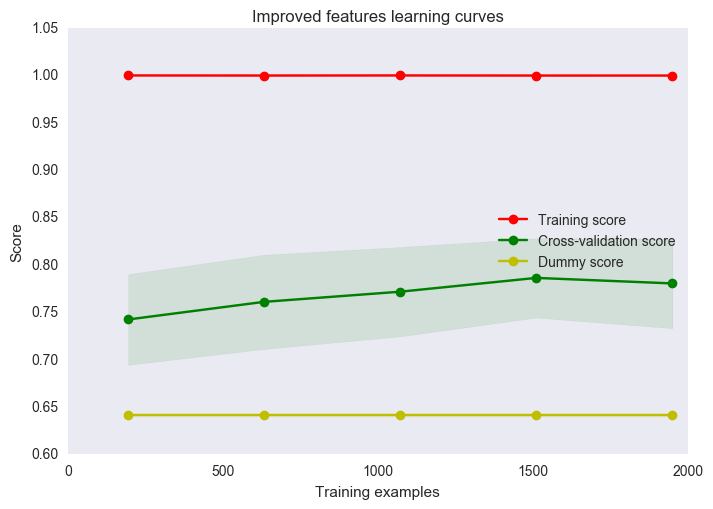

In [138]:
estimator = RandomForestClassifier(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
dummy_estimator = DummyClassifier(strategy='most_frequent')
helpers.plot_learning_curve(estimator, 'Improved features learning curves', x_training, y_training,n_jobs=N_JOBS, cv=20, dummy=dummy_estimator)

As we can see, the result for the black-white classification is better than the others. This can be explained in the sense that data don't allow to predict precisely the skintone.

As we can see, the difference between a _most-frequent dummy classifier_, the trained one has better performance. 

The average quality of the predictor increase while the number of data is added. However, the variance 